In [2]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import tensor
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Euler's ODE initial value solver
def ode_solver(z0,t0,t1,f):
  h_max=0.05
  n_steps=math.ceil((abs(t1-t0)/h_max).max().item())
  h=(t1-t0)/n_steps
  t=t0
  z=z0
  
  for i_step in range(n_steps):
    z=z+h*f(z,t)
    t=t+h
  
  return z

In [ ]:
#parametrized dynamics functions
#   flatten all dependent functions
#   compute aug. dynamics (depends on gradient of function wrt inputs and params)

class ODEF(nn.Module):
  def flatten_parameters(self):
    p_shapes=[]
    flat_params=[]
    for p in self.parameters():
      p_shapes.append(p.size())
      flat_params.append(p.flatten())
    
    return torch.cat(flat_params)

  def augmented_dynamics_util(self,z,t,grad_outputs):
    batch_size=z.shape[0]
    out=self.forward(z,t) #def below in encapsulated fn ##forward pass output
    a=grad_outputs
    adfdz,adfdt,*adfdp=torch.autograd.grad(
        (out,),(z,t)+tuple(self.parameters()),grad_outputs=(a),
        allow_unused=True,retain_graph=True
    )
    '''
    adfdz==a[df/dz]
    adfdt==s[df/dt]
    *adfdp=a[df/dp] #* unpacks the list into position values
    '''

    if adfdp is not None:
      adfdp=torch.cat([grad.flatten() for grad in adfdp]).unsqueeze(0)
      adfdp=adfdp.expand(batch_size-1)/batch_size

    if adfdt is not None:
      adfdt=adfdt.expand(batch_size-1)/batch_size
    
    return out,adfdz,adfdt,adfdp

In [3]:
#forward and backward pass of Neural ODE (NODE) 
#wrapped in a class
class ODEAdjoint(torch.autograd.Function):
  @staticmethod
  def forward(ctx,z0,t,flat_params,func):
    assert isinstance(func, ODEF)
    bs, *z_shape=z0.size()
    time_len=t.size(0)

    with torch.no_grad():
      z=torch.zeros(time_len,bs,*z_shape).to(z0)
      z[0]=z0
      for i_t in range(time_len-1):
        z0=ode_solver(z0,t[i_t],t[i_t+1],func)
        z[i_t+1]=z0
    ctx.func=func
    ctx.save_for_backward(t,z.clone(),flat_parameters)
    
    return z

  @staticmethod
  def backward(ctx,dLdz):
    func=ctx.func
    t,z,flat_parameters=ctx.saved_tensors
    time_len,bs,*z_shape=z.size()
    n_dim=np.prod(z_shape)
    n_params=flat_parameters.size(0)

    #aug dynamics to be calc backwards wrt time
    def augmented_dynamics(aug_z_i,t_i):
      '''
      tensors here are defined as temporal slices
      t_i is a tensor with size (bs,l)
      aug_z_i is a tensor with size (bs,n_dims*2+n_params+1)
      '''
      z_i,a=aug_z_i[:,:n_dim],aug_z_i[:,n_dim:2*n_dim]
      z_i=z_i.view(bs,*z_shape)
      a=a.view(bs,*z_shape)
      with torch.set_grad_enabled(True):
        t_i=t_i.detach().requires_grad_(True)
        z_i=z_i.detach().requires_grad_(True)
        func_eval,adfdz,adfdt,adfdp=func.forward_with_grad(z_i,t_i,grad_outputs=a)
        adfdz=adfdz.to(z_i) if adfdz is not None else torch.zeros(bs,*z_shape).to(z_i)
        adfdp=adfdp.to(z_i) if adfdz is not None else torch.zeros(bs,n_params).to(z_i)
        adfdt=adfdt.to(z_i) if adfdz is not None else torch.zeros(bs,1).to(z_i)
        
      func_eval=func_eval.view(bs,n_dim)
      adfdz=adfdz.view(bs,n_dim)
      
      return torch.cat((func_eval,-adfdz,-adfdp,-adfdt),dim=1)

    dLdz=dLdz.view(time_len,bs,n_dim)
    #create placeholders for output gradients
    with torch.no_grad():
      adj_z=torch.zeros(bs,n_dim).to(dLdz)
      adj_p=torch.zeros(bs,n_params).to(dLdz)
      adj_t=torch.zeros(time_len,bs,1).to(dLdz) #gradients for all times

      for i_t in range(time_len-1,0,-1):
        z_i=z[i_t]
        t_i=t[i_t]
        f_i=func(z_i,t_i).view(bs,n_dim)

        #direct gradients
        dLdz_i=dLdz[i_t]
        dLdt_i=torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1),1,2),f_i.unsqueeze(-1))[:,0]

        adj_z+=dLdz_i
        adj_t[i_t]=adj_t[i_t]-dLdt_i
        aug_z=torch.cat((z_i.view(bs,n_dim),adj_z,torch.zeros(bs,n_params).to(z),adj_t[i_t]),dim=-1)
        aug_ans=ode_solver(aug_z,t_i,t[i_t-1],augmented_dynamics)

        #unpack
        adj_z[:]=aug_ans[:,n_dim:2*n_dim]
        adj_p[:]=aug_ans[:,2*n_dim:2*n_dim+n_params]
        adj_t[i_t-1]=aug_ans[:,2*n_dim+n_params:]

        del aug_z,aug_ans

      dLdz_0=dLdz[0]
      dLdt_0=torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1),1,2),f_i.unsqueeze(-1))[:,0]

      adj_z+=dLdz_0
      adj_t[0]=adj_t[0]-dLdt_0

    return adj_z.view(bs,*z_shape),adj_t,adj_p,None

In [5]:
#wrapper class
class NeuralODE(nn.Module):
  def __init__(self,func):
    super(NeuralODE,self).__init__()
    assert isinstance(func,ODEF)
    self.func=func

  def forward(self,z0,t=tensor([0.,1.]),return_whole_sequence=False):
    t=t.to(z0)
    z=ODEAdjoint.apply(z0,t,self.func.flatten_params(),self.func)
    if return_whole_sequence:
      return z
    else:
      return z[-1]

Using the author's code <br>
Can be found here : https://github.com/rtqichen/torchdiffeq

In [6]:
!git clone https://github.com/rtqichen/torchdiffeq.git
!pip install -e /content/torchdiffeq

Cloning into 'torchdiffeq'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 303 (delta 30), reused 43 (delta 18), pack-reused 229
Receiving objects: 100% (303/303), 8.09 MiB | 1.56 MiB/s, done.
Resolving deltas: 100% (137/137), done.
Obtaining file:///content/torchdiffeq
  Running setup.py develop for torchdiffeq


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#author's lib
#NOTE: Restart notebook/kernel to avoid ImportError for odeint
from torchdiffeq import odeint, odeint_adjoint

In [5]:
help(odeint_adjoint)

Help on function odeint_adjoint in module torchdiffeq._impl.adjoint:

odeint_adjoint(func, y0, t, rtol=1e-06, atol=1e-12, method=None, options=None, adjoint_rtol=None, adjoint_atol=None, adjoint_method=None, adjoint_options=None)



True


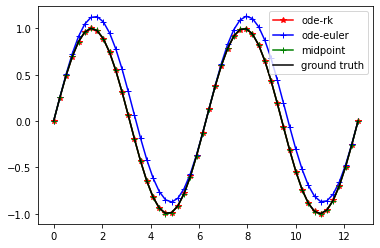

In [4]:
t=np.linspace(0,4*np.pi,num=50)
tt=torch.from_numpy(t).float()

z0=torch.tensor([0]).float() #initial value
fn=lambda t,z:torch.cos(t)
print(callable(fn))

euler=odeint(fn,z0,tt,method='euler').squeeze().numpy()
midpoint=odeint(fn,z0,tt,method='midpoint').squeeze().numpy()
rk=odeint(fn,z0,tt).squeeze().numpy() #default method: Runge-Kutta

plt.plot(t,rk,'r*-',label='ode-rk')
plt.plot(t,euler,'b+-',label='ode-euler')
plt.plot(t,midpoint,'g+-',label='midpoint')
plt.plot(t,np.sin(t),'k-',label='ground truth')
plt.legend(loc='best')

torch.Size([2, 1])
(50, 2)


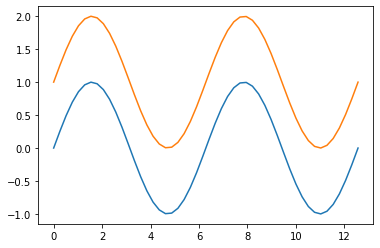

In [6]:
y0=torch.tensor([[0],[1]]).float()
print(y0.shape)
values=odeint(fn,torch.tensor([[0],[1]]).float(),tt).squeeze().numpy()
print(values.shape)

plt.plot(t,values[:,0])
plt.plot(t,values[:,1])

In [7]:
#https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html#resnet18
from torchvision.models.resnet import ResNet, BasicBlock

class MnistResNet18(ResNet):
    def __init__(self):
        super(MnistResNet18,self).__init__(BasicBlock,[2,2,2,2],num_classes=10)
        #replace first conv layer to accept single-channel image
        self.conv1=nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3,bias=False)
        
    def forward(self, x):
        return F.softmax(super(MnistResNet18, self).forward(x),dim=-1)

In [8]:
from torchvision.datasets import MNIST
from torchvision.transforms import Compose,ToTensor,Normalize,Resize
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
import inspect

In [9]:
mnist=MNIST(root='.',train=True,download=True)
#normalization for MNIST in Pytorch: https://discuss.pytorch.org/t/normalization-in-the-mnist-example/45

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [10]:
train_bs=64
test_bs=64
transform=Compose([Resize((224,224)),ToTensor(),Normalize((0.01307,),(0.3081,))])
train_ds=MNIST(root='.',train=True,download=True,transform=transform)
train_loader=DataLoader(train_ds,batch_size=train_bs,shuffle=True,num_workers=4)
test_ds=MNIST(root='.',train=False,download=True,transform=transform)
test_loader=DataLoader(test_ds,batch_size=test_bs,shuffle=True,num_workers=4)

In [11]:
n_epochs=2
lr=0.001
loss_fn=nn.CrossEntropyLoss()
model=MnistResNet18()
optimizer=optim.Adam(model.parameters(),lr=0.001)

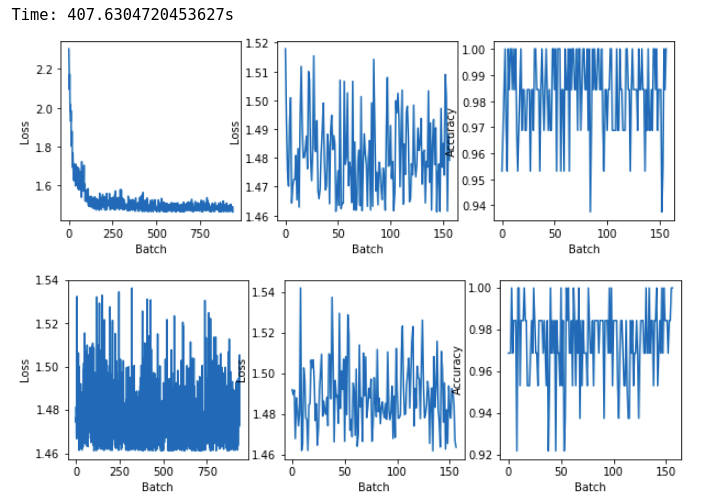

In [17]:

start_ts=time.time()

for epoch in range(n_epochs):
  train_losses=[]
  model.train()
  for batch in train_loader:
    bx,by=batch[0],batch[1]
    
    model.zero_grad()
    pred_logits=model(bx)
    loss=loss_fn(pred_logits,by)
    train_losses.append(loss.item())
    #backprop
    loss.backward()
    optimizer.step()

  test_losses=[]
  test_acc=[]
  #eval on test data, no backprop
  model.eval()
  with torch.no_grad():
    for batch in test_loader:
      bx,by=batch[0],batch[1]
      pred_logits=model(bx)
      loss=loss_fn(pred_logits,by)
      test_losses.append(loss.item())

      pred_by=torch.argmax(pred_logits,1)
      test_acc.append(accuracy_score(by,cpu(),pred_by.cpu()))

  fig,ax=plt.subplots(1,3,figsize=(10,3))
  ax[0].plot(train_losses,label='Epoch {}: Train Loss'.format(epoch+1))
  ax[0].set_xlabel('Batch')
  ax[0].set_ylabel('Loss')

  ax[1].plot(train_losses,label='Epoch {}: Test Loss'.format(epoch+1))
  ax[1].set_xlabel('Batch')
  ax[1].set_ylabel('Loss')

  ax[2].plot(test_acc,label='Epoch {}: Test Accuracy'.format(epoch+1))
  ax[2].xlabel('Batch')
  ax[2].ylabel('Accuracy')

print(f"Time: {time.time()-start_ts}s")
